In [1]:
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Flatten, ZeroPadding2D, Activation
from keras.preprocessing.image import ImageDataGenerator
import h5py
import os
import cv2
import csv
import math
import tensorflow as tf
import numpy as np

Using TensorFlow backend.


In [2]:
vgg16_model = keras.applications.vgg16.VGG16(weights='Z:/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

In [3]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
model = Sequential()

for layer in vgg16_model.layers[:-3]:
    
    model.add(layer)
    
for layer in model.layers:
    
    layer.trainable = False

In [5]:
model.add(Dense(1000,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(4,activation='relu'))

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [7]:
model.load_weights('Z:/JupyterNotebooks/VGG16_smoke-0.22.h5')
print('Loading Complete')

Loading Complete


In [8]:
from keras.utils import Sequence

train_images_path = 'Z:/Smoke_DataSet2/Test/'
valid_images_path = 'Z:/Smoke_DataSet2/Valid/'
train_CSV_file = 'Z:/Smoke_DataSet2/Test.csv'
valid_CSV_file = 'Z:/Smoke_DataSet2/Valid.csv'
img_size = 224

class DataGenerator(Sequence):
    
    def __init__(self,csv_file,img_path,num,batch_size=25):
        
        self.csv_file = csv_file
        self.x = []
        self.y = np.zeros((int(num),4))
        self.batch_size = batch_size
        self.length = 0
        
        with open(self.csv_file,"r") as csv_data:
            csv_reader = csv.reader(csv_data, delimiter=',')
            line_no = 0
            
            for row in csv_reader:
                if line_no != 0:
                    
                    w = int(row[1])
                    h = int(row[2])
                    minx = abs(int(row[4]))
                    miny = abs(int(row[5]))
                    maxx = abs(int(row[6]))
                    maxy = abs(int(row[7]))
                    
                    self.y[line_no-1][0] = (minx/w)*img_size
                    self.y[line_no-1][1] = (miny/h)*img_size
                    self.y[line_no-1][2] = (maxx/w)*img_size
                    self.y[line_no-1][3] = (maxy/h)*img_size
                    
                    #self.y.append([minx,miny,maxx,maxy])
                    self.x.append(img_path + row[0])
                    line_no += 1
                    
                else:
                    line_no += 1
        self.length = (math.ceil(len(self.x) / self.batch_size))
        print(len(self.x),self.length)
        print(self.y)
                    
    def __loadimages(self,batch):
            
        img = []
            
        for filename in batch:
                
            im = cv2.resize(cv2.imread(filename), (img_size, img_size))
            img.append(im)
                
        return np.array(img)
            
    def __len__(self):
        return self.length
                
    def __getitem__(self,idx):
            
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
            
        images = self.__loadimages(batch_x).astype('float32')
            
        return images,batch_y
            
        
        
        

In [9]:
train_datagen = DataGenerator(train_CSV_file,train_images_path,955,32)
valid_datagen = DataGenerator(valid_CSV_file,valid_images_path,100,25)

955 30
[[  0.           0.         223.3        211.86666667]
 [  0.           0.         210.         188.125     ]
 [  0.           0.         222.25       222.25      ]
 ...
 [ 91.35        21.15555556 124.13333333 133.15555556]
 [ 82.13333333   2.48888889 114.45       138.75555556]
 [ 88.2         32.56296296 121.56666667 135.02222222]]
100 4
[[7.00000000e+00 0.00000000e+00 2.23125000e+02 2.22250000e+02]
 [4.90000000e+01 4.48000000e+01 2.23300000e+02 2.18400000e+02]
 [6.90666667e+01 1.15266667e+02 2.22755556e+02 2.05800000e+02]
 [8.75000000e-01 0.00000000e+00 2.22250000e+02 2.08250000e+02]
 [3.25629630e+01 3.11111111e-01 2.22340741e+02 2.00666667e+02]
 [0.00000000e+00 0.00000000e+00 2.22962963e+02 2.02222222e+02]
 [8.75000000e-01 0.00000000e+00 1.45250000e+02 2.19625000e+02]
 [5.25000000e+00 0.00000000e+00 2.22250000e+02 2.23125000e+02]
 [8.75000000e-01 8.75000000e-01 2.21375000e+02 2.22250000e+02]
 [2.10000000e+01 4.14814815e-01 1.69633333e+02 2.15288889e+02]
 [3.32500000e+01 8.75

In [10]:

checkpoint = keras.callbacks.ModelCheckpoint("VGG16a_smoke-{loss:.2f}.h5", 
                             monitor="loss", 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=True, 
                             mode="auto", 
                             period=1)

model.compile(loss=keras.losses.mean_squared_logarithmic_error, 
              optimizer=keras.optimizers.adam(lr=0.005), 
              metrics=["accuracy"])


In [11]:
model.evaluate_generator(valid_datagen,steps=1,verbose=1)

1/1 [==============================] - 12s 12s/step


[2.733365774154663, 0.47999998927116394]

In [12]:
history = model.fit_generator(train_datagen, 
                    steps_per_epoch=100, 
                    epochs=2, 
                    validation_data=valid_datagen,
                    validation_steps=25,
                    callbacks=[checkpoint])

Epoch 1/2
 28/100 [=======>......................] - ETA: 3:04 - loss: 0.8853 - acc: 0.6027

KeyboardInterrupt: 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


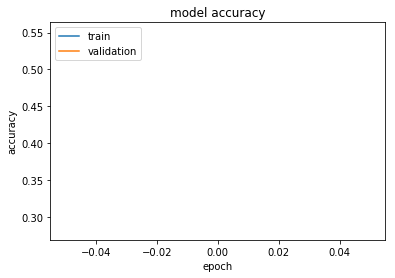

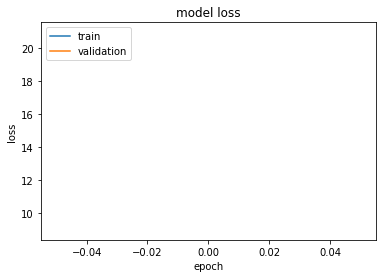

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [25]:
model.load_weights('Z:/JupyterNotebooks/VGG16_smoke-0.22.h5')
print('Loading Complete')

model.evaluate_generator(valid_datagen,steps=1,verbose=1)
#model.evaluate_generator(train_datagen,steps=1,verbose=1)

Loading Complete
1/1 [==============================] - 2s 2s/step


[2.733365774154663, 0.47999998927116394]

1/1 [==============================] - 2s 2s/step
[[ 28.67218     9.29229   193.49126   196.8936   ]
 [ 55.137573   16.288082  214.19646   207.20595  ]
 [ 90.916306  123.55455   189.04668   227.43324  ]
 [ 46.39658    36.210793  156.67906   165.596    ]
 [ 43.61694    96.46589   148.99799   191.04878  ]
 [  8.0304     55.82332   107.28519   148.53436  ]
 [  5.3520584   2.0512958  85.4318     87.733604 ]
 [ 21.18727     4.1320453 183.18036   179.66875  ]
 [ 42.294247   42.756397  127.201744  142.636    ]
 [ 45.760292    0.        135.17683   185.01407  ]
 [ 15.274725   16.730972  104.079506  113.69464  ]
 [ 24.273935   18.26475   146.08203   154.51262  ]
 [ 10.276698   28.761528  120.31355   139.2907   ]
 [ 21.333096   46.896595  111.95844   137.40091  ]
 [  7.316314   27.071991  111.28792   131.7082   ]
 [ 17.745674   11.604754  134.01064   144.9857   ]
 [ 32.243874   44.635895  139.7383    160.77522  ]
 [  0.926855    1.3816767 143.36905   148.13991  ]
 [ 98.6279     96.93862   134.00

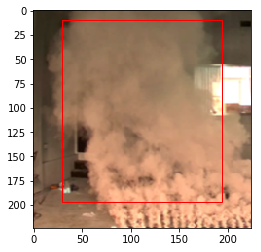

0


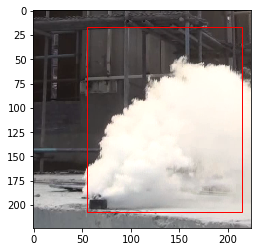

1


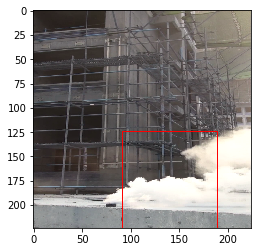

2


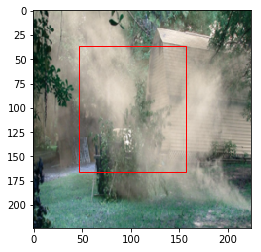

3


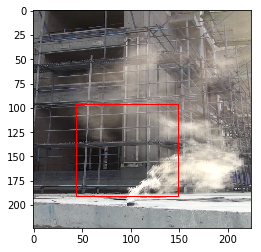

4


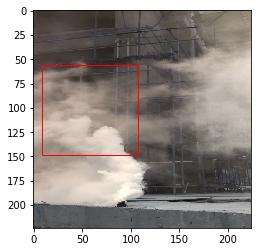

5


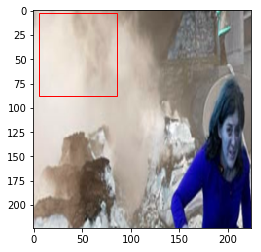

6


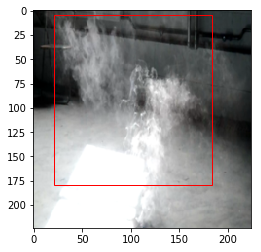

7


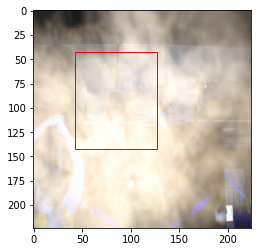

8


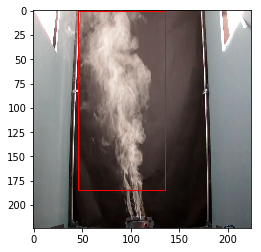

9


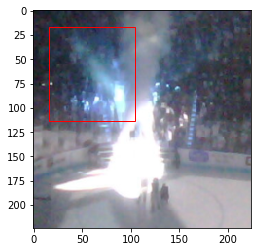

10


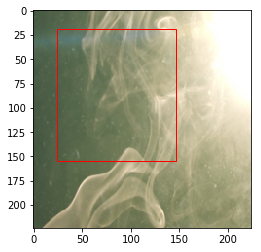

11


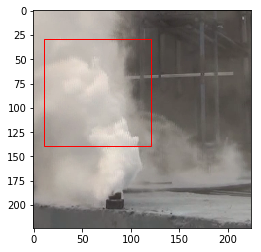

12


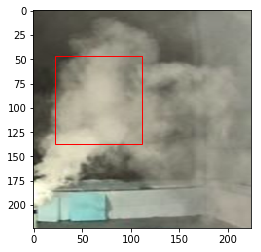

13


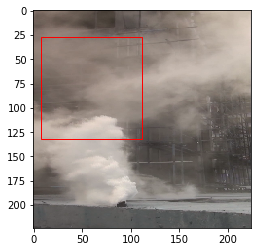

14


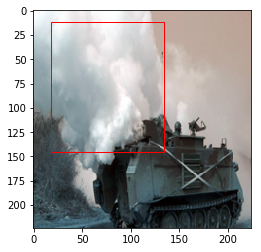

15


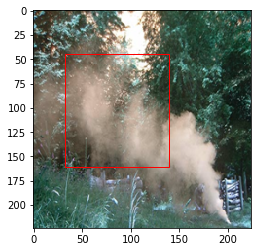

16


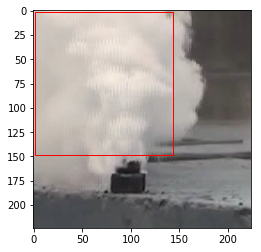

17


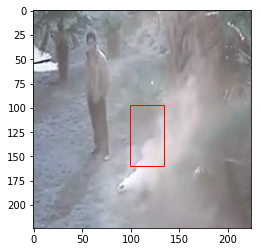

18


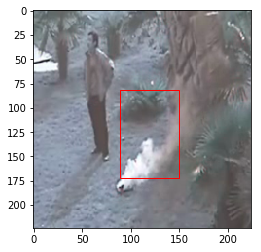

19


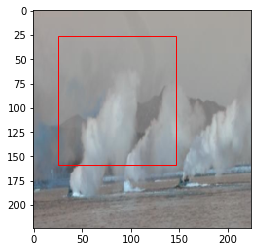

20


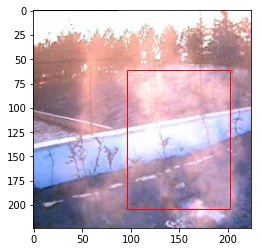

21


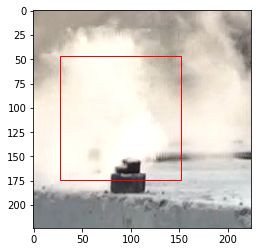

22


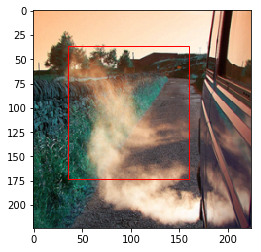

23


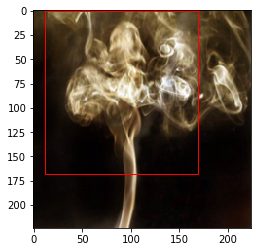

24


IndexError: index 25 is out of bounds for axis 0 with size 25

In [30]:
pred_array = model.predict_generator(valid_datagen, steps=1, verbose=1)

print(pred_array)

#import matplotlib.pyplot as plt
import matplotlib.patches as patches
count = 0

for img,label in valid_datagen:
    
    for im in img:

        xm,ym = pred_array[count][0],pred_array[count][1]
        wt = (pred_array[count][2] - pred_array[count][0])
        ht = (pred_array[count][3] - pred_array[count][1])
        im = np.array(img[count],dtype=np.uint8)
        fig,ax = plt.subplots(1)
        ax.imshow(im)
        rect = patches.Rectangle((xm,ym),wt,ht,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.show()
        fig.savefig('Z:/pred_outputs/pred_' + str(count) + '.png')
        print(count)
        count += 1